# Анализ данных, содержащих транзакции онлайн магазина из Великобритании за 1 год

#### Данные на платформе Kaggle:  https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business/data 

Датасет содержит 500 тыс. строк и 8 столбцов. 

**Описание:**

TransactionNo (categorical): шестизначный уникальный номер каждой транзакции. Литера “C” в обозначении говорит об отмененной транзакции

Date (numeric): дата создания транзакции.

ProductNo (categorical): пяти- или шести- значный уникальный код, используемый для идеентификации товаров 

Product (categorical): наименование товара

Price (numeric): цена каждого продукта в фунтах стерлингов.

Quantity (numeric): количество каждого продукта в каждой транзакции. Отрицательные цифры говорят о возврате

CustomerNo (categorical): пятизначный уникальный номер покупателя

Country (categorical): название страны покупателя

## В данном блокноте я сделал следующую работу: 

* разведочный анализ данных;
* анализ данных в разрезах стран;
* анализ данных в разрезах покупателей;
* определил метрики, которые буду информативны для бизнеса;
* провел когортный анализ;
* рассчитал процент удержания покупателей для каждого квартала;
* провел RFM сегментацию;
* оформил дашборд с графиками.

####  Импортирую библиотеки

In [271]:
%matplotlib inline
# База для работы с данными и визуализации
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Построение карты мира
import geopandas as gpd

# Пригодится в RFM анализе
from datetime import timedelta

# Для загрузки данных с диска
import requests 
from urllib.parse import urlencode

# Игнорировать все предупреждения
import warnings
warnings.filterwarnings('ignore'

#### Загружаю данные в sales_df

In [2]:
# Использую api для загрузки датафрейма с пользователями
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/I1YMGet0WVOOVA'

# Получаю url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

# Записываю файл в датафрейм
download_response = requests.get(download_url) 
sales_df = pd.read_csv(download_url, sep=',') 

# EDA

In [3]:
sales_df.info()
# customerNO - 55 пропусков - в общем объеме не критично -  удалил
# дата в формате строки - переделал в datetime
# customerNO типа float, нужно int или object - сделал

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


#### Перевожу столбец даты в формат datetime и столбец CustomerNo в object

In [4]:
sales_df.Date       = pd.to_datetime(sales_df.Date, format='%m/%d/%Y')
sales_df.CustomerNo = sales_df.CustomerNo.dropna().astype(int).astype(object)

#### Перевожу имена столбцов в нижний регистр  для удобства

In [5]:
sales_df.columns = map(str.lower, sales_df.columns)
sales_df.rename(columns={
                         'transactionno': 'transaction_no',
                         'productno': 'product_no',
                         'productname': 'product_name',
                         'customerno': 'customer_no'
                         }, inplace=True)
sales_df

,transaction_no,date,product_no,product_name,price,quantity,customer_no,country
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069,United Kingdom
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069,United Kingdom
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069,United Kingdom
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,2018-12-01,22168,Organiser Wood Antique White,18.96,-2,12472,Germany
536346,C536548,2018-12-01,21218,Red Spotty Biscuit Tin,14.09,-3,12472,Germany
536347,C536548,2018-12-01,20957,Porcelain Hanging Bell Small,11.74,-1,12472,Germany
536348,C536548,2018-12-01,22580,Advent Calendar Gingham Sack,16.35,-4,12472,Germany


#### Посчитаю количество уникальных заказов (в разрезах)

In [6]:
print(f'Всего:      {sales_df.transaction_no.nunique()} шт.')
print(f"Отмененных: {sales_df.query('quantity < 0').transaction_no.nunique()} шт.")
print(f"Успешных:   {sales_df.transaction_no.nunique() - sales_df.query('quantity < 0').transaction_no.nunique()} шт.")

Всего:      23204 шт.
Отмененных: 3414 шт.
Успешных:   19790 шт.


#### Посчитаю количество возвращенных товаров

In [7]:
sales_df = sales_df.drop_duplicates()
cancel_transactions = sales_df.transaction_no.str.startswith("C").sum()
print(f'Количество возвращенных заказов:{cancel_transactions} шт')

Количество возвращенных заказов:8548 шт


#### Посчитаю количество уникальных товаров

In [8]:
print(f'Всего уникальных товаров: {sales_df.product_no.nunique()} шт.')

Всего уникальных товаров: 3768 шт.


#### Посмортю на цены

In [9]:
print(f'Максимальная цена: {sales_df.price.max()}')
print(f'Минимальная цена:  {sales_df.price.min()}')

Максимальная цена: 660.62
Минимальная цена:  5.13


#### Количество уникальных покупателей

In [10]:
print(f'Количество уникальных покупателей: {sales_df.customer_no.nunique()} чел')

Количество уникальных покупателей: 4738 чел


#### Количество уникальных покупателей по странам и месяцам

In [11]:
sales_df['date_month'] = sales_df['date'].dt.strftime('%Y-%m')
unique_customers_country = sales_df.groupby(['country','date_month'])['customer_no'].nunique().reset_index()
unique_customers_country

,country,date_month,customer_no
0,Australia,2018-12,3
1,Australia,2019-01,7
2,Australia,2019-02,4
3,Australia,2019-03,4
4,Australia,2019-04,3
...,...,...,...
297,Unspecified,2019-05,2
298,Unspecified,2019-06,1
299,Unspecified,2019-07,3
300,Unspecified,2019-08,2


#### Из каких стран были заказы?

In [12]:
countries = sales_df.country.unique()
print(f'Число уникальных стран, включая неопределенные: {sales_df.country.nunique()}')
print(f'Список стран: {countries}')

Число уникальных стран, включая неопределенные: 38
Список стран: ['United Kingdom' 'Norway' 'Belgium' 'Germany' 'France' 'Austria'
 'Netherlands' 'EIRE' 'USA' 'Channel Islands' 'Iceland' 'Portugal' 'Spain'
 'Finland' 'Italy' 'Greece' 'Japan' 'Sweden' 'Denmark' 'Cyprus' 'Malta'
 'Switzerland' 'Australia' 'Czech Republic' 'Poland' 'Hong Kong'
 'Singapore' 'RSA' 'Israel' 'Unspecified' 'United Arab Emirates' 'Canada'
 'European Community' 'Bahrain' 'Brazil' 'Saudi Arabia' 'Lebanon'
 'Lithuania']


#### Из каких стран больше всего уникальных покупателей?

In [13]:
customers_per_country = sales_df.groupby('country')['customer_no']\
                                .nunique()\
                                .sort_values(ascending = False)\
                                .reset_index()\
                                .rename(columns = {'customer_no':'cust_count'})
customers_per_country

,country,cust_count
0,United Kingdom,4324
1,Germany,92
2,France,87
3,Spain,23
4,Belgium,22
5,Switzerland,21
6,Portugal,18
7,EIRE,13
8,Italy,12
9,Finland,12


#### Посчитаю выручку с каждой транзакции по месяцам

In [14]:
sales_df['revenue'] = sales_df['price'] * sales_df['quantity']
monthly_revenue = sales_df.groupby('date_month')['revenue']\
                          .sum()\
                          .reset_index()
monthly_revenue

,date_month,revenue
0,2018-12,4217196.99
1,2019-01,3638085.05
2,2019-02,3291955.62
3,2019-03,4339649.36
4,2019-04,3405988.90
5,2019-05,4521865.67
6,2019-06,4401861.55
7,2019-07,4495987.99
8,2019-08,4605702.03
9,2019-09,6529256.45


#### Рассчитаю метрику ARPU

In [16]:
unique_cust_dynamics = unique_customers_country.groupby('date_month')['customer_no'].sum()
arpu = monthly_revenue.merge(unique_cust_dynamics.reset_index(), on = 'date_month')
arpu['arpu'] = round(arpu['revenue'] / arpu['customer_no'],2)
arpu

,date_month,revenue,customer_no,arpu
0,2018-12,4217196.99,1086,3883.24
1,2019-01,3638085.05,867,4196.18
2,2019-02,3291955.62,880,3740.86
3,2019-03,4339649.36,1125,3857.47
4,2019-04,3405988.90,981,3471.96
5,2019-05,4521865.67,1178,3838.60
6,2019-06,4401861.55,1156,3807.84
7,2019-07,4495987.99,1093,4113.44
8,2019-08,4605702.03,1039,4432.82
9,2019-09,6529256.45,1363,4790.36


#### Создам 2 датафрейма: без отмененных транзакций и только с отмененными транзакциями

In [17]:
sales_quant  = sales_df.query('quantity > 0')
sales_cancel = sales_df.query('quantity < 0')

# Сделаю анализ по 3 странам с наибольшим количеством уникальных покупателей (для нас это >50 чел)

### Великобритания


#### Посчитаю число заказов для каждого пользователя (customer_no) из Великобритании (United Kingdom). Оставлю только тех, кто совершил больше транзакций, чем 80% процентиль.

In [18]:
# Отбираю данные по Великобритании
UK_data = sales_quant.query('country == "United Kingdom"')

# Подсчитаю число заказов для каждого пользователя
orders_per_user = UK_data.groupby('customer_no')['transaction_no'].nunique()

# Вычисляю 80-процентиль количества заказов
percentile_80 = orders_per_user.quantile(0.8)

# Отбираю пользователей, у которых количество заказов больше 80-процентиля
UK_top = orders_per_user[orders_per_user > percentile_80].index
print(UK_top)

Int64Index([12557, 12610, 12747, 12748, 12779, 12826, 12828, 12830, 12839,
            12841,
            ...
            18226, 18229, 18230, 18236, 18241, 18245, 18257, 18260, 18272,
            18283],
           dtype='int64', name='customer_no', length=853)


#### Используя объекты с id пользователей (UK_top), полученные на предыдущем шаге, отфильтрую наблюдения и оставлю в данных записи только по интересующим меня юзерам. Результирующий датафрейм запишу в top_retail_UK.

In [19]:
# Создаю датафрейм с данными
top_retail_UK = sales_quant.query('customer_no in @UK_top')
top_retail_UK

,transaction_no,date,product_no,product_name,price,quantity,customer_no,country,date_month,revenue
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom,2019-12,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069,United Kingdom,2019-12,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069,United Kingdom,2019-12,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069,United Kingdom,2019-12,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069,United Kingdom,2019-12,71.64
...,...,...,...,...,...,...,...,...,...,...
536314,536564,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,4,13468,United Kingdom,2018-12,81.80
536318,536582,2018-12-01,22634,Childs Breakfast Set Spaceboy,20.45,2,12947,United Kingdom,2018-12,40.90
536319,536582,2018-12-01,22635,Childs Breakfast Set Dolly Girl,20.45,2,12947,United Kingdom,2018-12,40.90
536320,536585,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,2,17460,United Kingdom,2018-12,40.90


#### Кто из покупателей во Великобритании принес больше всего выручки?

In [20]:
# Создаю столбец со стоимстью каждых товаров внутри заказа
top_retail_UK['order_cost'] = top_retail_UK['quantity'] * top_retail_UK['price']

# Группирую по покупателям и считаю стоимость заказов для каждого
best_customers_UK = top_retail_UK.groupby('customer_no')\
                                 .agg({'order_cost':'sum'})\
                                 .reset_index()\
                                 .rename(columns = {'order_cost':'total_profit'})\
                                 .sort_values(by = 'total_profit', ascending=False)
best_customers_UK.head()

,customer_no,total_profit
826,18102,897137.36
719,17450,891069.53
129,13694,646116.78
727,17511,639006.19
232,14298,635526.37


#### Какие товары в Великобритании добавлялись в корзину чаще остальных, а какие реже остальных?

In [21]:
# Группирую данные по названию товара и суммирую количество каждого
top_UK_goods = top_retail_UK.groupby('product_name')\
                            .agg({'quantity':'sum'})\
                            .reset_index()\
                            .sort_values(by = 'quantity', ascending=False)
top_UK_goods

,product_name,quantity
2353,Popcorn Holder,36213
1593,Jumbo Bag Red Retrospot,33017
3485,World War 2 Gliders Asstd Designs,32872
786,Cream Hanging Heart T-Light Holder,23226
194,Assorted Colour Bird Ornament,23222
...,...,...
2665,Set 10 Card Perfect Nativity 17089,1
3430,White Vintage Crystal Earrings,1
3429,White Vintage Crystal Bracelet,1
134,Amber Bertie Glass Bead Bag Charm,1


#### Какие товары в Великобритании покупатели возвращали чаще остальных, а какие реже?

In [22]:
# Убираю отрицательные знаки для значений в столбце quantity
sales_cancel['quantity'] = sales_cancel['quantity'].abs()

In [23]:
# Отбираю значения для Великобритании, группирую по названию товара и суммирую количества каждого
cancel_goods_UK  = sales_cancel.query('country == "United Kingdom"')\
                                  .groupby('product_name')\
                                  .agg({'quantity':'sum'})\
                                  .reset_index()\
                                  .sort_values(by = 'quantity', ascending = False)
cancel_goods_UK

,product_name,quantity
1061,Paper Craft Little Birdie,80995
925,Medium Ceramic Top Storage Jar,74467
1301,Rotating Silver Angels T-Light Hldr,9361
521,Fairy Cake Flannel Assorted Colour,3150
389,Cream Hanging Heart T-Light Holder,2551
...,...,...
1209,Red Metal Beach Spade,1
1083,Peace Wooden Block Letters,1
1082,Peace Small Wood Letters,1
1586,Trellis Coat Rack,1


### Германия

#### Посчитаю число заказов для каждого пользователя (customer_no) из Германии (Germany). Оставлю только тех, кто совершил больше транзакций, чем 80% процентиль.

In [24]:
germany_data = sales_quant.query('country == "Germany"')

# Подсчитаю числа заказов для каждого пользователя
orders_per_user = germany_data.groupby('customer_no')['transaction_no'].nunique()

# Вычисляю 80-процентиль количества заказов
percentile_80 = orders_per_user.quantile(0.8)

# Отбираю пользователей, у которых количество заказов больше 80-процентиля
germany_top = orders_per_user[orders_per_user > percentile_80].index
print(germany_top)

Int64Index([12471, 12474, 12476, 12481, 12500, 12524, 12569, 12600, 12619,
            12621, 12626, 12647, 12662, 12705, 12708, 12709, 12712, 12720],
           dtype='int64', name='customer_no')


#### Используя объект с id пользователей (germany_top), полученный на предыдущем шаге, отфильтрую наблюдения и оставлю в данных записи только по интересующим меня юзерам. Результирующий датафрейм запишите в top_retail_germany.

In [25]:
# Создаю датафрейм с данными
top_retail_germany = sales_quant.query('customer_no in @germany_top')
top_retail_germany

,transaction_no,date,product_no,product_name,price,quantity,customer_no,country,date_month,revenue
1425,581570,2019-12-09,22141,Christmas Craft Tree Top Angel,6.19,6,12662,Germany,2019-12,37.14
1426,581570,2019-12-09,22175,Pink Owl Soft Toy,6.19,6,12662,Germany,2019-12,37.14
1427,581570,2019-12-09,21481,Fawn Blue Hot Water Bottle,6.19,4,12662,Germany,2019-12,24.76
1428,581570,2019-12-09,23570,Traditional Pick Up Sticks Game,6.19,12,12662,Germany,2019-12,74.28
1429,581570,2019-12-09,22326,Round Snack Boxes Set Of4 Woodland,6.19,6,12662,Germany,2019-12,37.14
...,...,...,...,...,...,...,...,...,...,...
534337,536527,2018-12-01,22973,Children's Circus Parade Mug,11.94,12,12662,Germany,2018-12,143.28
534338,536527,2018-12-01,84569B,Pack 3 Fire Engine/Car Patches,11.53,12,12662,Germany,2018-12,138.36
534339,536527,2018-12-01,22549,Picture Dominoes,11.74,12,12662,Germany,2018-12,140.88
534340,536527,2018-12-01,20712,Jumbo Bag Woodland Animals,6.13,10,12662,Germany,2018-12,61.30


#### Кто из покупателей в Германии принес больше всего выручки?

In [26]:
# Создаю столбец со стоимстью каждых товаров внутри заказа
top_retail_germany['order_cost'] = top_retail_germany['quantity'] * top_retail_germany['price']

# Группирую по покупателям и считаю стоимость заказов для каждого
best_customers = top_retail_germany.groupby('customer_no')\
                                   .agg({'order_cost':'sum'})\
                                   .reset_index()\
                                   .rename(columns = {'order_cost':'total_profit'})\
                                   .sort_values(by = 'total_profit', ascending=False)
best_customers.head()

,customer_no,total_profit
0,12471,90851.48
9,12621,78735.47
5,12524,57952.31
1,12474,55693.11
17,12720,48257.02


#### Какие товары в Германии добавлялись в корзину чаще остальных, а какие реже остальных?

In [27]:
# Группирую данные по названию продукта и суммирую количества
top_germany_goods = top_retail_germany.groupby('product_name')\
                                      .agg({'quantity':'sum'})\
                                      .reset_index()\
                                      .sort_values(by = 'quantity', ascending=False)
top_germany_goods

,product_name,quantity
768,Pack Of 6 Birdy Gift Tags,880
975,Regency Cakestand 3 Tier,675
451,Funky Diva Pen,628
1029,Round Snack Boxes Set Of4 Woodland,626
561,Jam Making Set Printed,624
...,...,...
836,Pink Bertie Mobile Phone Charm,1
128,Blue Dragonfly Helicopter,1
838,Pink Butterfly Handbag W Bobbles,1
135,Blue Heart Compact Mirror,1


#### Какие товары в Германии покупатели возвращали чаще остальных, а какие реже?

In [216]:
# Отбираю значения для Германии, группирую по названию товара и суммирую количества каждого
cancel_goods_Ge  = sales_cancel.query('country == "Germany"')\
                               .groupby('product_name')\
                               .agg({'quantity':'sum'})\
                               .reset_index()\
                               .sort_values(by = 'quantity', ascending = False)    
cancel_goods_Ge

,product_name,quantity
30,Boys Alphabet Iron On Patches,288
164,Regency Cakestand 3 Tier,72
84,Gumball Coat Rack,42
11,5 Hook Hanger Magic Toadstool,34
10,36 Pencils Tube Woodland,32
...,...,...
38,Ceramic Cake Bowl + Hanging Cakes,1
67,Felt Farm Animal Rabbit,1
141,Porcelain Hanging Bell Small,1
185,Set 20 Napkins Fairy Cakes Design,1


#### Франция

#### Посчитаю число заказов для каждого пользователя (customer_no) из Франции (France). Оставлю только тех, кто совершил больше транзакций, чем 80% процентиль.

In [29]:
france_data = sales_quant.query('country == "France"')

# Подсчет числа заказов для каждого пользователя
orders_per_user = france_data.groupby('customer_no')['transaction_no'].nunique()

# Вычисление 80-процентиля количества заказов
percentile_80 = orders_per_user.quantile(0.8)

# Отбор пользователей, у которых количество заказов больше 80-процентиля
france_top = orders_per_user[orders_per_user > percentile_80].index
print(france_top)

Int64Index([12437, 12490, 12523, 12553, 12567, 12583, 12637, 12678, 12681,
            12682, 12683, 12731],
           dtype='int64', name='customer_no')


#### Используя объект с id пользователей (france_top), полученный на предыдущем шаге, отфильтрую наблюдения и оставлю в данных записи только по интересующим меня юзерам. Результирующий датафрейм запишите в top_retail_france.

In [30]:
# Создаю датафрейм с данными
top_retail_france = sales_quant.query('customer_no in @france_top')
top_retail_france

,transaction_no,date,product_no,product_name,price,quantity,customer_no,country,date_month,revenue
3713,581279,2019-12-08,22215,Cake Stand White Two Tier Lace,6.19,12,12437,France,2019-12,74.28
3714,581279,2019-12-08,22423,Regency Cakestand 3 Tier,6.19,6,12437,France,2019-12,37.14
6563,581001,2019-12-07,23562,Set Of 6 Ribbons Perfectly Pretty,6.19,6,12583,France,2019-12,37.14
6564,581001,2019-12-07,22540,Mini Jigsaw Circus Parade,6.19,48,12583,France,2019-12,297.12
6565,581001,2019-12-07,22544,Mini Jigsaw Spaceboy,6.19,48,12583,France,2019-12,297.12
...,...,...,...,...,...,...,...,...,...,...
533303,536370,2018-12-01,22900,Set 2 Tea Towels I Love London,13.27,24,12583,France,2018-12,318.48
533304,536370,2018-12-01,21913,Vintage Seaside Jigsaw Puzzles,14.09,12,12583,France,2018-12,169.08
533305,536370,2018-12-01,22540,Mini Jigsaw Circus Parade,10.68,24,12583,France,2018-12,256.32
533306,536370,2018-12-01,22544,Mini Jigsaw Spaceboy,10.68,24,12583,France,2018-12,256.32


#### Кто из покупателей во Франции принес больше всего выручки?

In [214]:
# Создаю столбец со стоимстью каждых товаров внутри заказа
top_retail_france['order_cost'] = top_retail_france['quantity'] * top_retail_france['price']

# Группирую по покупателям и считаю стоимость заказов для каждого
best_customers_fr = top_retail_france.groupby('customer_no')\
                                   .agg({'order_cost':'sum'})\
                                   .reset_index()\
                                   .rename(columns = {'order_cost':'total_profit'})\
                                   .sort_values(by = 'total_profit', ascending=False)\
                                   .head(10)
best_customers_fr

,customer_no,total_profit
7,12678,120696.22
11,12731,102510.58
8,12681,86451.58
9,12682,58072.69
5,12583,56248.77
10,12683,55540.22
4,12567,49397.22
6,12637,34091.30
3,12553,33396.70
0,12437,33137.62


#### Какие товары во Франции добавлялись в корзину чаще остальных, а какие реже остальных?

In [218]:
# Группирую данные по названию продукта и суммирую количества
top_france_goods = top_retail_france.groupby('product_name')\
                                    .agg({'quantity':'sum'})\
                                    .reset_index()\
                                    .sort_values(by = 'quantity', ascending=False)
top_france_goods

,product_name,quantity
678,Rabbit Night Light,3121
521,Mini Paint Set Vintage,1296
55,Assorted Colour Bird Ornament,1168
888,Set/6 Red Spotty Paper Cups,842
655,Plasters In Tin Circus Parade,785
...,...,...
958,Tea Time Party Bunting,1
120,Bull Dog Bottle Opener,1
963,Toilet Sign Occupied Or Vacant,1
818,Set Of 16 Vintage Rose Cutlery,1


#### Какие товары во Франции покупатели возвращали чаще остальных, а какие реже?

In [219]:
# Отбираю значения для Германии, группирую по названию товара и суммирую количества каждого
cancel_goods_Fr = sales_cancel.query('country == "France"')\
                               .groupby('product_name')\
                               .agg({'quantity':'sum'})\
                               .reset_index()\
                               .sort_values(by = 'quantity', ascending = False)
cancel_goods_Fr

,product_name,quantity
105,Wrap Christmas Village,250
33,Fridge Magnets La Vie En Rose,120
35,Fridge Magnets Us Diner Assorted,120
34,Fridge Magnets Les Enfants Assorted,120
13,Card Christmas Village,72
...,...,...
75,Red Retrospot Mini Cases,1
74,Red Retrospot Childrens Umbrella,1
67,Plasters In Tin Spaceboy,1
21,Circus Parade Childrens Egg Cup,1


# Когортный анализ

In [34]:
# Расссчитал когортный период (когортный шаг) для каждой записи в датасете summary_df и записал данные в отдельный столбец
sales_quant['cohort_period'] = np.arange(len(sales_quant)) + 1

In [35]:
# Сделал новый датафрейм cohorts и поместил в него только уникальные ID и временную отметку оплаты заказа
cohorts = sales_quant[['customer_no', 'date']]
cohorts.dropna()

# Проверил типы данных и пустые значения: все столбцы строковые и пустых значений нет
cohorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522602 entries, 0 to 536324
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_no  522601 non-null  object        
 1   date         522602 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 12.0+ MB


In [36]:
# Далее я сделал в датафрейме и датасете столбец с месяцем заказа
cohorts['order_month'] = cohorts['date'].dt.strftime('%Y-%m')
sales_quant['order_month'] = sales_quant['date'].dt.to_period('M')
cohorts.head()

,customer_no,date,order_month
0,17490,2019-12-09,2019-12
1,13069,2019-12-09,2019-12
2,13069,2019-12-09,2019-12
3,13069,2019-12-09,2019-12
4,13069,2019-12-09,2019-12


In [37]:
# Создал еще один датафрейм с данным для когортного анализаа, забрав необходимые поля из summary_df
cohort_data = sales_quant[['customer_no', 'transaction_no', 'date', 'order_month']]\
               .sort_values('order_month')

# Далее я определил месяц первого заказа для каждого пользователя путем соединения датафрейма с самим собой 
# и группировки по уникальному ID c агрегирующей функцией first
cohort_data['cohort_month'] = cohort_data.groupby('customer_no')['order_month']\
                                         .transform('first')
cohort_data

,customer_no,transaction_no,date,order_month,cohort_month
536324,18011,536597,2018-12-01,2018-12,2018-12
508280,15566,538566,2018-12-13,2018-12,2018-12
508279,15566,538566,2018-12-13,2018-12,2018-12
508278,15566,538566,2018-12-13,2018-12,2018-12
508277,15566,538566,2018-12-13,2018-12,2018-12
...,...,...,...,...,...
16852,16729,580729,2019-12-05,2019-12,2018-12
16853,16729,580729,2019-12-05,2019-12,2018-12
16854,16729,580729,2019-12-05,2019-12,2018-12
16880,16729,580729,2019-12-05,2019-12,2018-12


In [38]:
# Следующим шагом я сгруппировал пользователей в когорты, на основании месяца первого заказа
cohort_data = cohort_data.groupby(['cohort_month', 'order_month'])\
                    .agg({'customer_no': 'nunique'})\
                    .rename(columns={'customer_no':'cohorts_len'})\
                    .reset_index()
cohort_data # РАСККОММЕНТИРОВАТЬ для просмотра результата

,cohort_month,order_month,cohorts_len
0,2018-12,2018-12,1026
1,2018-12,2019-01,341
2,2018-12,2019-02,310
3,2018-12,2019-03,368
4,2018-12,2019-04,355
...,...,...,...
86,2019-10,2019-11,78
87,2019-10,2019-12,34
88,2019-11,2019-11,290
89,2019-11,2019-12,32


In [39]:
# Далее я вычислил когортные периоды при помощи lambda функции
cohort_data = cohort_data.groupby('cohort_month')\
        .apply(lambda x: x.assign(cohort_period = np.arange(len(x)) + 1))\
        .reset_index(drop = True)

cohort_data # РАСККОММЕНТИРОВАТЬ для просмотра результата

,cohort_month,order_month,cohorts_len,cohort_period
0,2018-12,2018-12,1026,1
1,2018-12,2019-01,341,2
2,2018-12,2019-02,310,3
3,2018-12,2019-03,368,4
4,2018-12,2019-04,355,5
...,...,...,...,...
86,2019-10,2019-11,78,2
87,2019-10,2019-12,34,3
88,2019-11,2019-11,290,1
89,2019-11,2019-12,32,2


In [40]:
# Отбираю данные только за 2019 год
cohort_data_19 = cohort_data.query('cohort_month >= "2019-01" & cohort_month <= "2019-12"')

In [41]:
# Создаю сводную таблицу, чтобы провернуть данные для удобного восприятия. Месяцы - индексы, периоды - колонки, размер - значения
cohorts_pivot = cohort_data_19.pivot(index='cohort_month', columns='cohort_period', values='cohorts_len')
cohorts_pivot

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2019-01,486.0,98.0,127.0,111.0,147.0,136.0,113.0,114.0,138.0,154.0,166.0,56.0
2019-02,438.0,83.0,80.0,114.0,115.0,98.0,105.0,117.0,103.0,132.0,30.0,NaN
2019-03,503.0,71.0,115.0,95.0,116.0,83.0,131.0,117.0,143.0,47.0,NaN,NaN
2019-04,321.0,66.0,60.0,63.0,62.0,74.0,69.0,83.0,25.0,NaN,NaN,NaN
2019-05,332.0,62.0,62.0,55.0,68.0,73.0,84.0,28.0,NaN,NaN,NaN,NaN
2019-06,274.0,48.0,41.0,60.0,62.0,79.0,29.0,NaN,NaN,NaN,NaN,NaN
2019-07,211.0,31.0,37.0,43.0,63.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,173.0,32.0,41.0,39.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,282.0,68.0,94.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


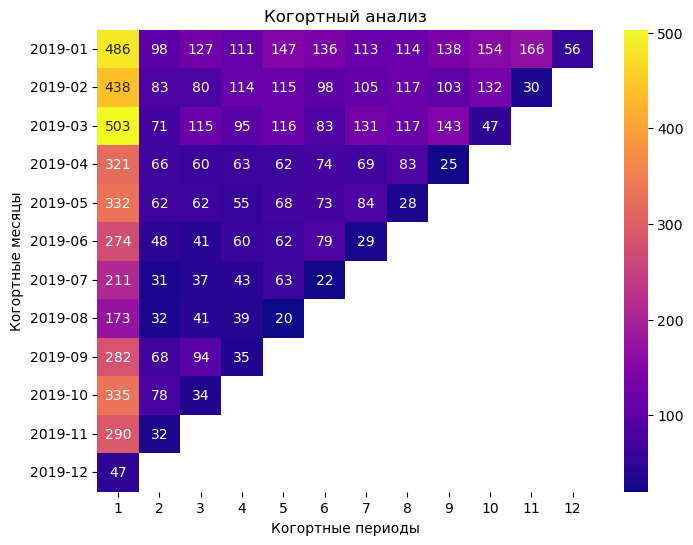

In [42]:
# Визуализирую данные с помощью тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(cohorts_pivot, annot=True, fmt='g', cmap='plasma')
plt.xlabel('Когортные периоды')
plt.ylabel('Когортные месяцы')
plt.title('Когортный анализ')
plt.show()

# Retention (удержание покупателей)

это метрика, отвечающая на вопрос, сколько людей вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт. Retention измеряется в процентах, то есть показывает долю вернувшихся людей от изначально пришедших.

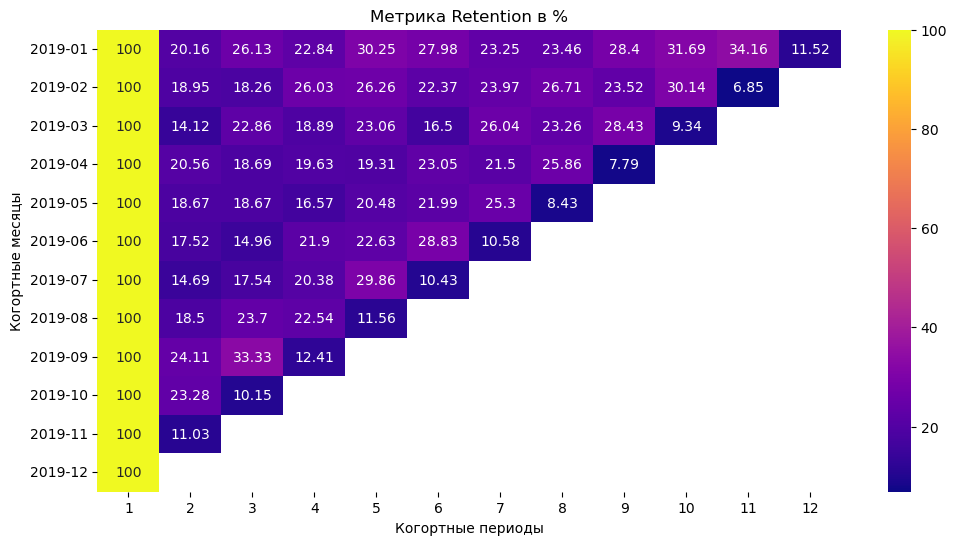

In [43]:
# Создаю сводную таблицу retention
retention_pivot = cohorts_pivot.copy()

# Считаю retention циклом for
for i in range(2, 13):
    retention_pivot[i] = cohorts_pivot[i] / cohorts_pivot[1]
    retention_pivot[i] = retention_pivot[i].apply(lambda x: round(x, 4) * 100 if pd.notna(x) else x)

# Делаю из 1 периода 100%
retention_pivot[1] = cohorts_pivot[1] / cohorts_pivot[1] * 100

# Визуализирую данные с помощью тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(retention_pivot, annot=True, fmt='g', cmap='plasma')
plt.xlabel('Когортные периоды')
plt.ylabel('Когортные месяцы')
plt.title('Метрика Retention в %')
plt.show()

In [44]:
# Рассчитал retention на 3, 6, 9 месяцы
retention_3rd_month = cohorts_pivot[3] / cohorts_pivot[1]
retention_6rd_month = cohorts_pivot[6] / cohorts_pivot[1]
retention_9rd_month = cohorts_pivot[9] / cohorts_pivot[1]

In [45]:
# Нахожу когорту с самым высоким retention на 3-й месяц
max_retention_cohort_3 = retention_3rd_month.idxmax()
max_retention_cohort_6 = retention_6rd_month.idxmax()
max_retention_cohort_9 = retention_9rd_month.idxmax()

print("Когорта с самым высоким retention на 3-й месяц:", max_retention_cohort_3)
print("Когорта с самым высоким retention на 6-й месяц:", max_retention_cohort_6)
print("Когорта с самым высоким retention на 9-й месяц:", max_retention_cohort_9)

Когорта с самым высоким retention на 3-й месяц: 2019-09
Когорта с самым высоким retention на 6-й месяц: 2019-06
Когорта с самым высоким retention на 9-й месяц: 2019-03


# RFM сегментация покупателей

In [46]:
# Создаю копию датафрейма без отмененных транзакций
rfm_df = sales_quant

#### Далее по методике я сделал переменную NOW:
- Сместил текущую дату на один день после последней покупки;
- NOW будет использоваться в качестве ориентира для расчета Recency очков.

In [47]:
NOW = rfm_df['date'].max() + timedelta(days=1)

#### Рассчитываю необходимые метрики для каждого пользователя:

* Regency (R) - время от последней покупки пользователя до текущей даты (чем ниже — тем лучше)
* Frequency (F) - суммарное количество покупок у пользователя за всё время
* Monetary (M) - сумма покупок за всё время

In [48]:
recency = (rfm_df.groupby('customer_no')\
                 .agg({'date': lambda x: (NOW - x.max()).days})\
                 .reset_index()\
                 .rename(columns={'date':'recency'}))

#Recency # РАСКОММЕНТИРОВАТЬ для просмотра

In [49]:
frequency = (rfm_df.groupby('customer_no')\
                   .agg({'date': 'count'})\
                   .reset_index()\
                   .rename(columns={'date':'frequency'})\
                   .sort_values('frequency', ascending=False))

#Frequency # РАСКОММЕНТИРОВАТЬ для просмотра

In [50]:
monetary = (rfm_df.groupby('customer_no')\
                  .agg({'price': 'sum'})\
                  .reset_index()\
                  .rename(columns={'price':'monetary'})
                  .sort_values('monetary', ascending=False))

#Monetary # РАСКОММЕНТИРОВАТЬ для просмотра

In [51]:
#Создаю датафрейм RFM путем слияния столбцов каждой метрики
RFM_table = (recency.merge(frequency, on='customer_no').merge(monetary, on='customer_no'))

#RFM_table# РАСКОММЕНТИРОВАТЬ для просмотра

#### Разобью метрики на 4 группы при помощи процентилей (квантилей)

In [52]:
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,customer_no,recency,frequency,monetary
0.25,13742.25,19.00,19.0,241.215
0.50,15249.50,54.00,50.0,629.720
0.75,16746.75,156.75,127.0,1635.370


In [53]:
# Преобразую квантили в словари для удобства использования
quantiles = quantiles.to_dict()

# Напишу 2 функции для Recency и Frequency+Monetary 
#x = значение в столбце, p = recency, monetary_value, frequency, d = словарь квартилей)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Для FM нумерация в обратном порядке!
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4


### Провожу RFM сегментацию покупателей

Я буду искать следующие сегменты: **Чемпионы**, **Лояльные**, **Оттекающие**, **Потерянные**

In [185]:
# Создам копию датафрейма
RFM_Segment = RFM_table.copy()
# Применю функции для расчета оценок по каждой метрике
RFM_Segment['R_score'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_score'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_score'] = RFM_Segment['monetary'].apply(FM_Class, args=('monetary',quantiles,))
# Рассчитываю RFM score
RFM_Segment['RFM_score'] = RFM_Segment.R_score.map(str)\
                         + RFM_Segment.F_score.map(str)\
                         + RFM_Segment.M_score.map(str)

In [208]:
# Чемпионы
champions = RFM_Segment[RFM_Segment['RFM_score'] == '444'].sort_values('monetary', ascending=False)

# Лояльные клиенты
loyal = RFM_Segment.query('(F_score >= 2) and (M_score >= 2) and (RFM_score != "444" and RFM_score != "111")').sort_values('monetary', ascending=False)

# Потерянные клиенты
lost = RFM_Segment[RFM_Segment['RFM_score'] == '111'].sort_values('recency', ascending=False)

# На пороге оттока (исключаем чемпионов, лояльных и потерянных клиентов)
churn = RFM_Segment[~RFM_Segment['customer_no'].isin(champions['customer_no']) & 
                    ~RFM_Segment['customer_no'].isin(loyal['customer_no']) & 
                    ~RFM_Segment['customer_no'].isin(lost['customer_no'])].sort_values('monetary', ascending=False)

#### Сделаю текстовую сводку

In [209]:
champions_count = champions.shape[0]
print(f'Чемпионов: {champions_count} чел.')

loyal_count = loyal.shape[0]
print(f'Лояльных клиентов: {loyal_count} чел.')

churn_count = churn.shape[0]
print(f'На пороге оттока: {churn_count} чел.')

lost_count = lost.shape[0]
print(f'Потерянных клиентов: {lost_count} чел.')

total_rfm_users = champions_count+loyal_count+churn_count+lost_count
print(f'Всего клиентов в RFM сегментах: {total_rfm_users} чел.')

print(f'Уникальных клиентов: {RFM_Segment.shape[0]} чел.')

Чемпионов: 507 чел.
Лояльных клиентов: 2946 чел.
На пороге оттока: 771 чел.
Потерянных клиентов: 494 чел.
Всего клиентов в RFM сегментах: 4718 чел.
Уникальных клиентов: 4718 чел.


# Строю графики для дашборда

#### Визуализирую страны, где есть покупатели

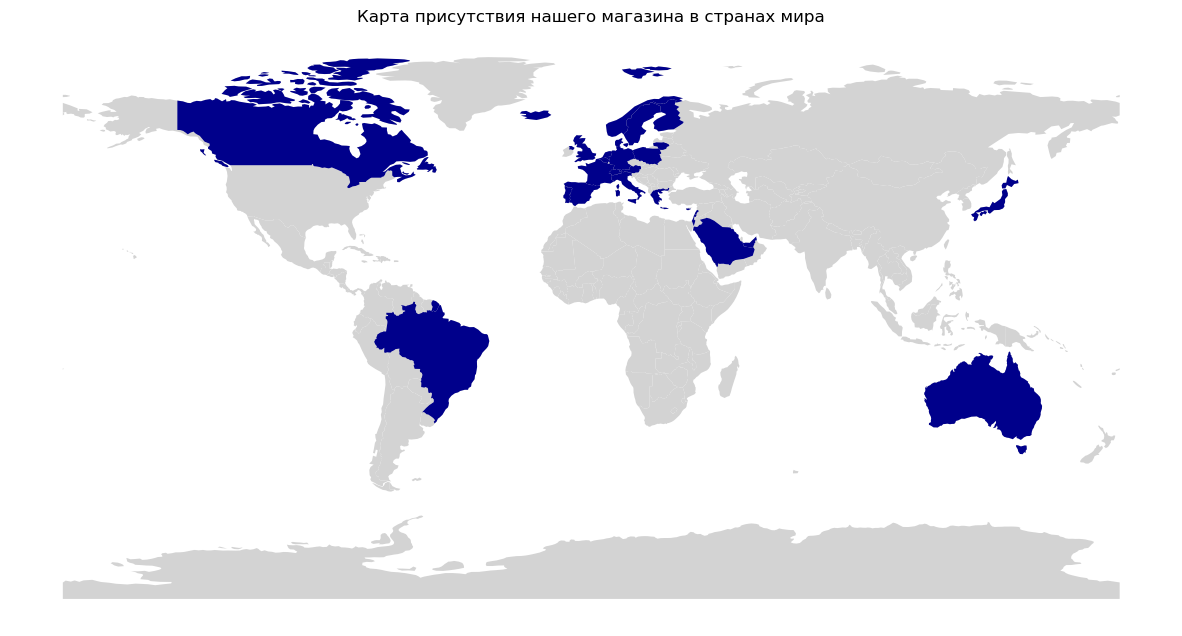

In [63]:
# Загрузка глобального набора данных границ стран
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Фильтрация DataFrame для включения только выбранных стран
world_selected = world[world['name'].isin(countries)]

# Создание базовой карты
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Отображение всего мира
world.plot(ax=ax, color='lightgrey')

# Отображение выбранных стран
world_selected.plot(ax=ax, color='darkblue')

# Добавление заголовка и удаление осей
ax.set_title('Карта присутствия нашего магазина в странах мира')
ax.axis('off')

# Показать карту
plt.show()

#### Построю график динамики уникальных пользователей в мире

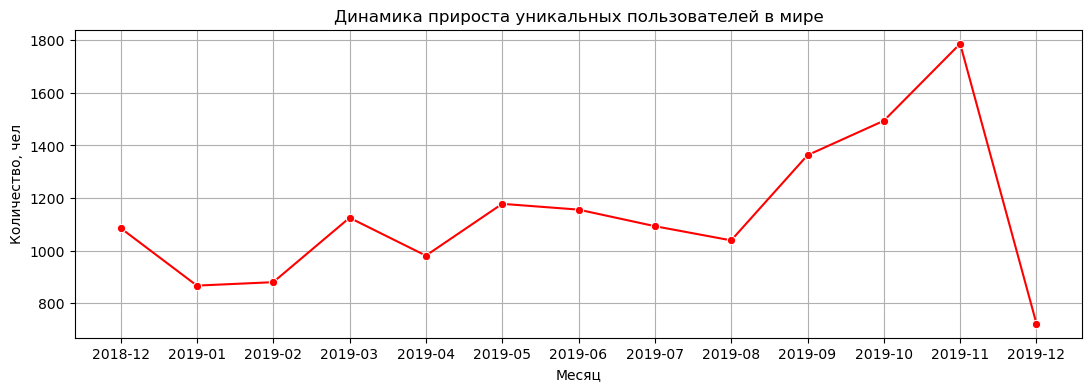

In [65]:
plt.figure(figsize=(13, 4))
sns.lineplot(data = unique_cust_dynamics,marker='o', color='r')
plt.xlabel('Месяц')
plt.ylabel('Количество, чел')
plt.title('Динамика прироста уникальных пользователей в мире')
plt.grid(True)
plt.show()

#### Построю график динамики прироста уникальных пользователей для Великобритании

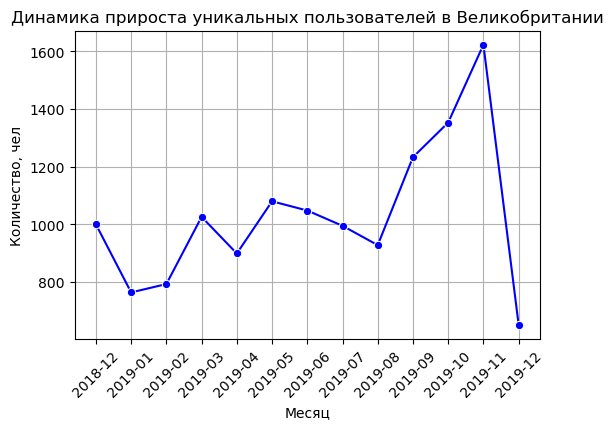

In [66]:
unique_cust_dynamics_UK = unique_customers_country.query('country == "United Kingdom"')\
                                                  .groupby('date_month')['customer_no']\
                                                  .sum()
plt.figure(figsize=(6, 4))
sns.lineplot(data = unique_cust_dynamics_UK,marker='o', color='b')
plt.xlabel('Месяц')
plt.ylabel('Количество, чел')
plt.title('Динамика прироста уникальных пользователей в Великобритании')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Построю график динамики прироста уникальных пользователей в Германии и Франции

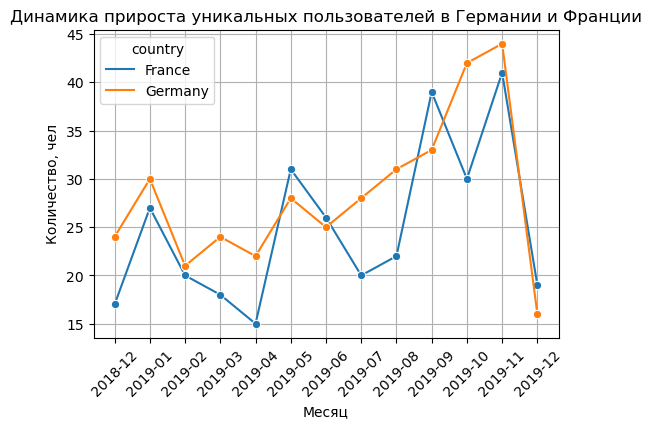

In [67]:
unique_cust_dynamics_GeFr = unique_customers_country.query('(country == "Germany") or (country == "France")')\
                                                  .groupby(['country','date_month'])['customer_no']\
                                                  .sum()\
                                                  .reset_index()
                                                  
plt.figure(figsize=(6, 4))
sns.lineplot(data = unique_cust_dynamics_GeFr, x = 'date_month', y = 'customer_no',marker='o', hue = 'country')
plt.xlabel('Месяц')
plt.ylabel('Количество, чел')
plt.title('Динамика прироста уникальных пользователей в Германии и Франции')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Построю график динамики выручки по месяцам

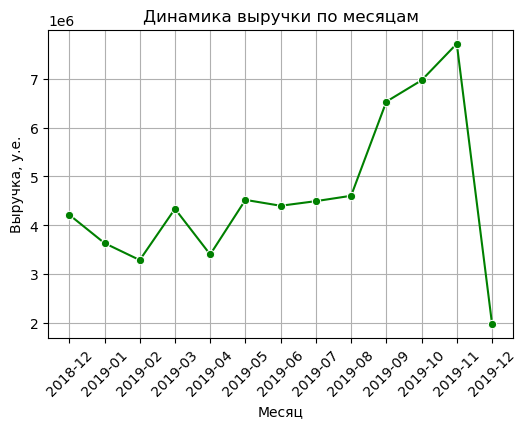

In [68]:
plt.figure(figsize=(6, 4))
sns.lineplot(data = monthly_revenue, x = 'date_month', y = 'revenue',marker='o', color = 'g')
plt.xlabel('Месяц')
plt.ylabel('Выручка, у.е.')
plt.title('Динамика выручки по месяцам')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Построю график доходов с пользователя

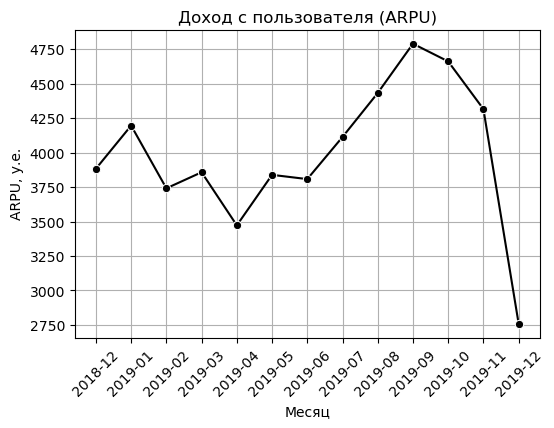

In [69]:
plt.figure(figsize=(6, 4))
sns.lineplot(data = arpu, x = 'date_month', y = 'arpu',marker='o', color = 'black')
plt.xlabel('Месяц')
plt.ylabel('ARPU, у.е.')
plt.title('Доход с пользователя (ARPU)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

####  Построю график количества покупателей в каждом сегменте

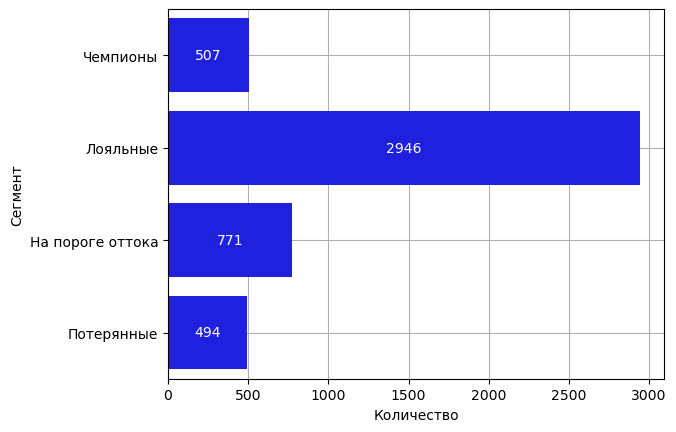

In [248]:
# Создам датафрейм для отрисовки столбчатой диаграммы
# Выделю отдельные столбцы
champions['segment'] = 'Чемпионы'
loyal['segment'] = 'Лояльные'
churn['segment'] = 'На пороге оттока'
lost['segment'] = 'Потерянные'

# Склею их в новый датафрейм и посчитаю количество каждой категории для будущего графика
combined_rfm = pd.concat([champions, loyal, churn, lost])
bar_data_rfm = combined_rfm['segment'].value_counts()\
                                      .reset_index()\
                                      .rename(columns = {'index':'Сегмент', 'segment':'Количество'})

# Устанавливаю порядок категорий по приоритетам
order = ['Чемпионы', 'Лояльные', 'На пороге оттока', 'Потерянные']

# Делаю переменную категориальной
bar_data_rfm['Сегмент'] = pd.Categorical(bar_data_rfm['Сегмент'], categories=order, ordered=True)

# Сортирую данные в соответствии с установленным порядком
bar_data_rfm = bar_data_rfm.sort_values('Сегмент')

# Делаю график (поскольку он кастомизированный, то использую ax)
ax = sns.barplot(data=bar_data_rfm, y='Сегмент', x='Количество', color='blue', orient='h')

# Делаю сетку и устанавливаю видимость за столбцами
ax.grid(True)
ax.set_axisbelow(True)

# Добавляю значения на вершины столбцов, центрируя их и делая белыми для читаемости
for p in ax.patches:
    width = p.get_width()
    ax.text(width / 2, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), 
            ha='center', va='center', color='white')
plt.show()

# Собираю дашборд

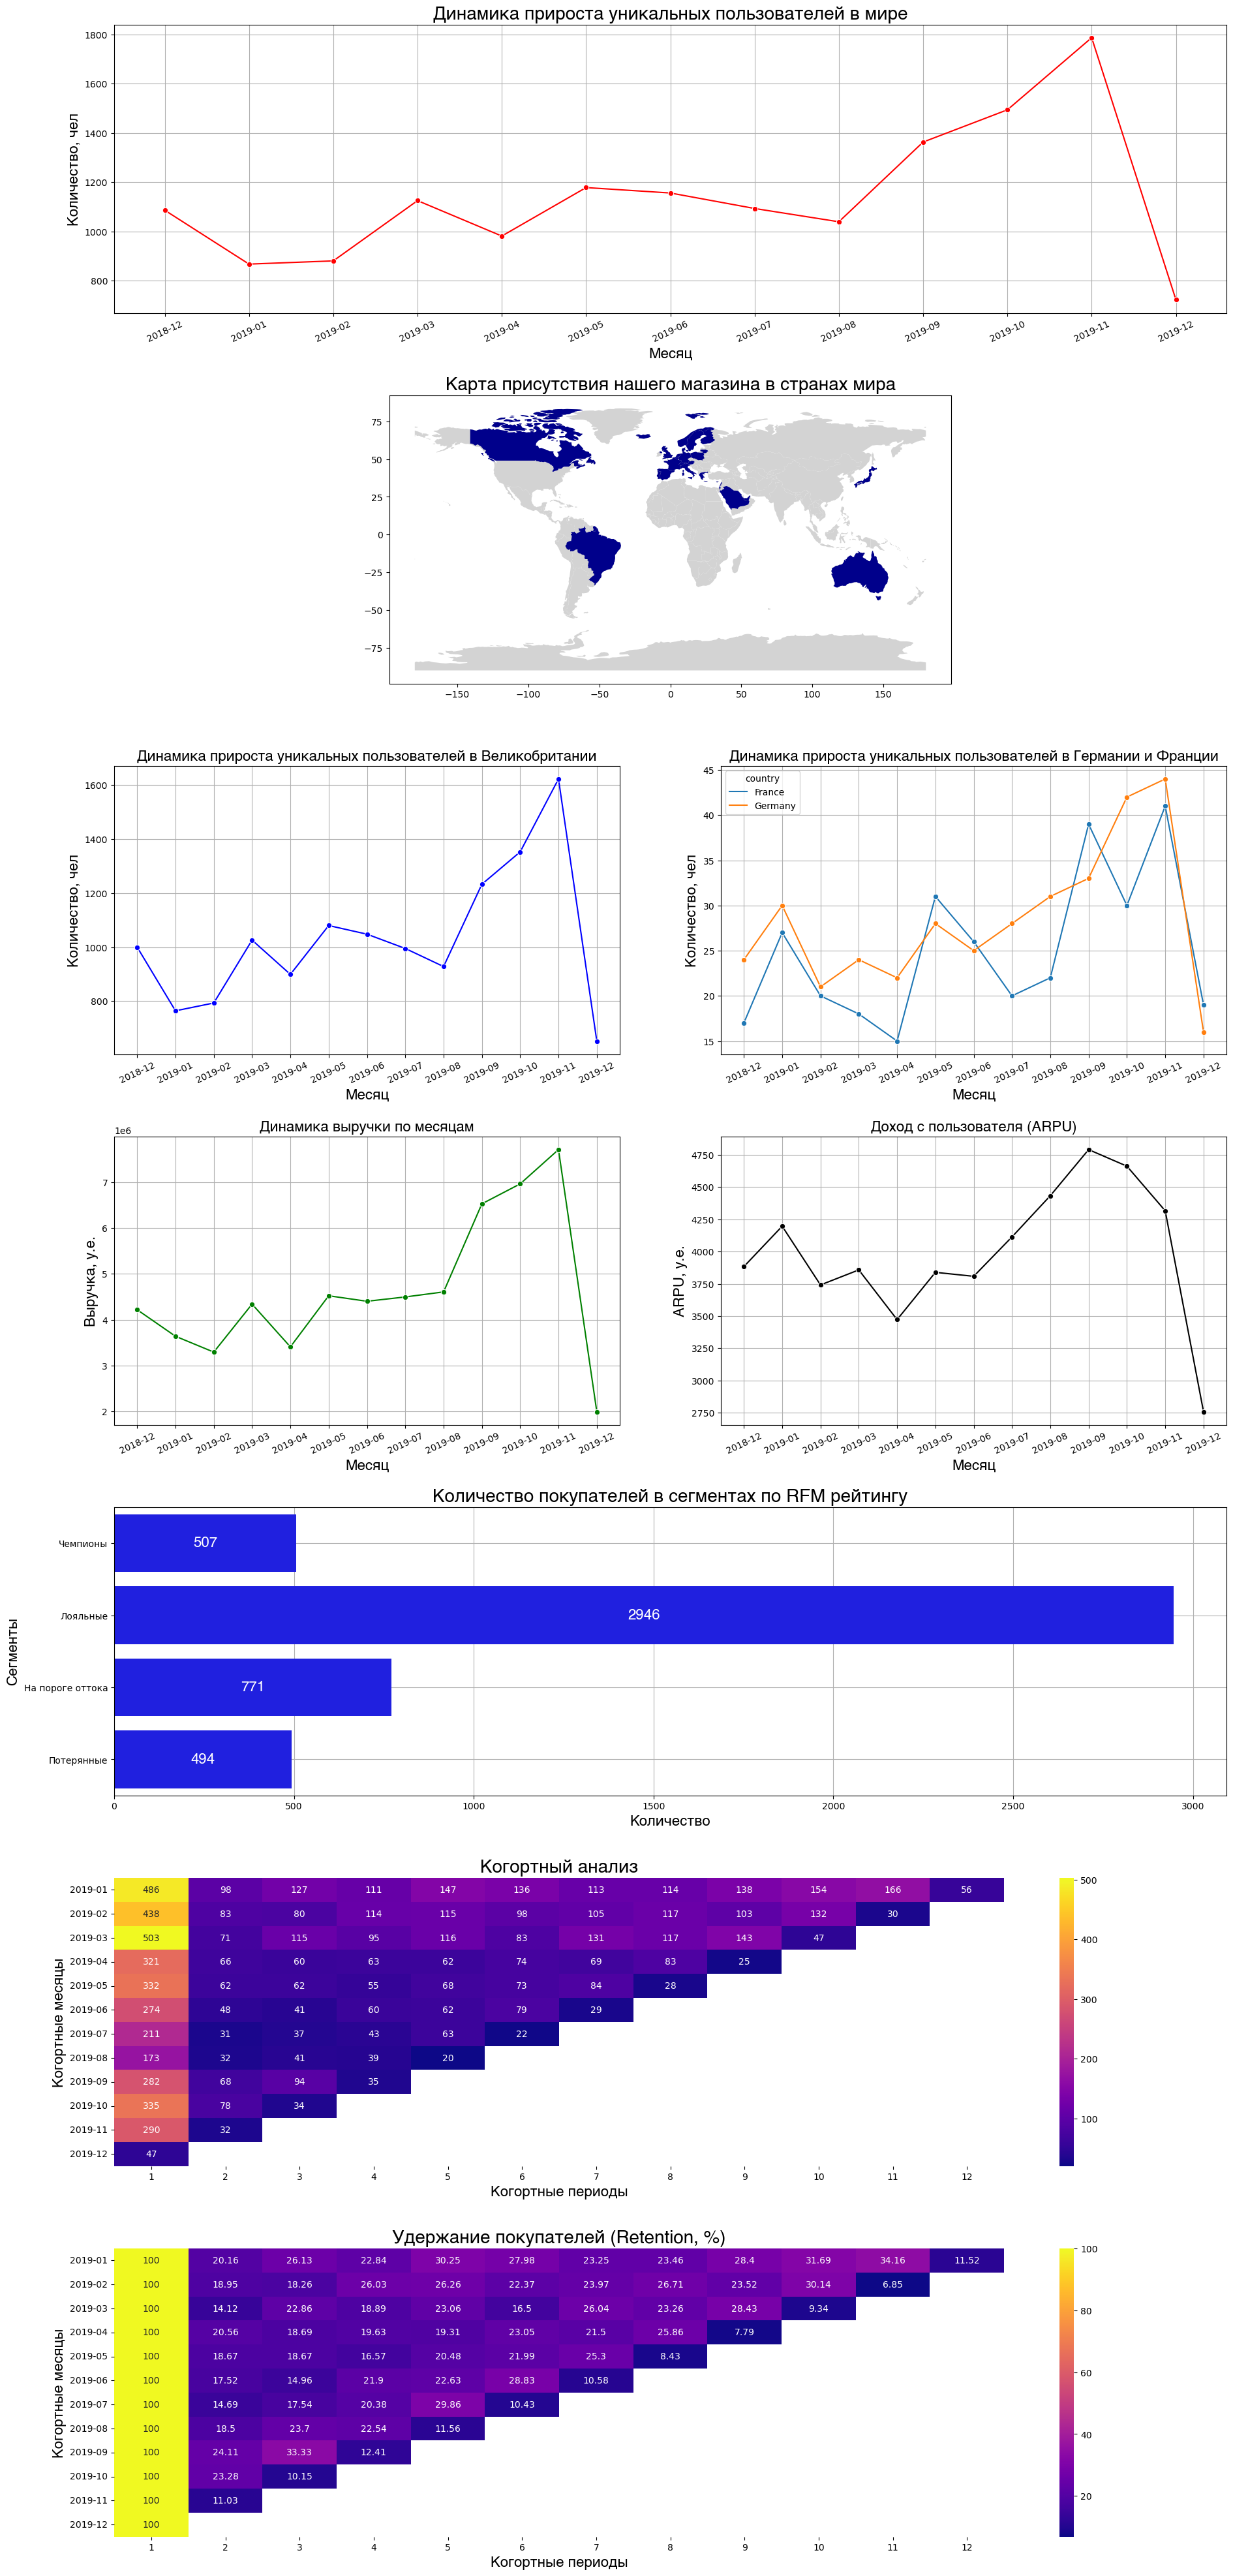

In [274]:
# Создаю разметку для размещения графиков
fig = plt.figure(figsize=(22, 50))

# Увеличиваем количество строк для размещения более крупного графика
gs = fig.add_gridspec(14, 2)  

# Управление расстоянием между графиками
plt.subplots_adjust(hspace=0.8)  # Увеличиваем вертикальное расстояние между графиками

ax = [None for _ in range(10)]

# Отрисовывваю график прироста уникальных пользоввателей в мире
ax[0] = fig.add_subplot(gs[0:2, : ])
sns.lineplot(data = unique_cust_dynamics,marker='o', color='r')
ax[0].set_xlabel('Месяц', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[0].set_ylabel('Количество, чел', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[0].set_title('Динамика прироста уникальных пользователей в мире', fontweight='bold',\
                                                                     fontsize=20,\
                                                                     fontname = 'Helvetica')
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=25)

# Отрисовывваю график с картой мира и нашим присутствием    
ax[1] = fig.add_subplot(gs[2:4, : ])
world.plot(ax=ax[1], color='lightgrey')
world_selected.plot(ax=ax[1], color='darkblue')
ax[1].set_title('Карта присутствия нашего магазина в странах мира', fontweight='bold',\
                                                                    fontsize=20,\
                                                                    fontname = 'Helvetica')
# Отрисовывваю график прироста уникальных пользовваателей для Великобритании
ax[2] = fig.add_subplot(gs[4:6, 0])
sns.lineplot(data = unique_cust_dynamics_UK,marker='o', color='b')
ax[2].set_xlabel('Месяц',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[2].set_ylabel('Количество, чел',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[2].set_title('Динамика прироста уникальных пользователей в Великобритании', fontweight='bold', \
                                                                               fontsize=16,\
                                                                               fontname = 'Helvetica')
ax[2].grid(True)  # Включает сетку
ax[2].tick_params(axis='x', rotation=25)

# Отрисовывваю график прироста уникальных пользовваателей для Германии и Франции    
ax[3] = fig.add_subplot(gs[4:6, 1])
sns.lineplot(data = unique_cust_dynamics_GeFr, x = 'date_month', y = 'customer_no',marker='o', hue = 'country')
ax[3].set_xlabel('Месяц', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[3].set_ylabel('Количество, чел', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[3].set_title('Динамика прироста уникальных пользователей в Германии и Франции', fontweight='bold',\
                                                                                   fontsize=16,\
                                                                                   fontname = 'Helvetica')  
ax[3].grid(True) 
ax[3].tick_params(axis='x', rotation=25)

# Отрисовывваю график динамики выручки  
ax[4] = fig.add_subplot(gs[6:8, 0])
sns.lineplot(data = monthly_revenue, x = 'date_month', y = 'revenue',marker='o', color = 'g')
ax[4].set_xlabel('Месяц',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[4].set_ylabel('Выручка, у.е.', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[4].set_title('Динамика выручки по месяцам', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[4].grid(True)
ax[4].tick_params(axis='x', rotation=25);
    
# Отрисовывваю график ARPU
ax[5] = fig.add_subplot(gs[6:8, 1])
sns.lineplot(data = arpu, x = 'date_month', y = 'arpu',marker='o', color = 'black')
ax[5].set_xlabel('Месяц',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[5].set_ylabel('ARPU, у.е.',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[5].set_title('Доход с пользователя (ARPU)', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[5].grid(True)
ax[5].tick_params(axis='x', rotation=25)

# Отрисовывваю график RFM сегментов
ax[6] = fig.add_subplot(gs[8:10, : ])
sns.barplot(data=bar_data_rfm, y='Сегмент', x='Количество', color='blue', orient='h')
ax[6].grid(True)
ax[6].set_axisbelow(True)
for p in ax[6].patches:
    width = p.get_width()
    ax[6].text(width / 2, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), 
               ha='center', va='center', color='white', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[6].set_xlabel('Количество', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[6].set_ylabel('Сегменты', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[6].set_title('Количество покупателей в сегментах по RFM рейтингу', fontweight='bold', fontsize=20, fontname = 'Helvetica')

# Отрисовывваю график когорт
ax[7] = fig.add_subplot(gs[10:12, : ])
sns.heatmap(cohorts_pivot, annot=True, fmt='g', cmap='plasma')
ax[7].set_xlabel('Когортные периоды', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[7].set_ylabel('Когортные месяцы', fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[7].set_title('Когортный анализ', fontweight='bold', fontsize=20, fontname = 'Helvetica')

# Отрисовывваю график retention
ax[8] = fig.add_subplot(gs[12:14, : ])
sns.heatmap(retention_pivot, annot=True, fmt='g', cmap='plasma')
ax[8].set_xlabel('Когортные периоды',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[8].set_ylabel('Когортные месяцы',fontweight='bold', fontsize=16, fontname = 'Helvetica')
ax[8].set_title('Удержание покупателей (Retention, %)', fontweight='bold', fontsize=20, fontname = 'Helvetica');
